# Trees

In [221]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [222]:
df = pd.read_csv('CreditScoring.csv')

In [223]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


## Data Cleaning

In [224]:
def standardise_colnames(df: pd.DataFrame) -> pd.DataFrame:
  df = df.copy()
  df.columns = df.columns.str.lower().str.replace(' ', '_')
  return df

In [225]:
df = standardise_colnames(df)

In [226]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [227]:
status_values = {
  0: 'unk',
  1: 'ok',
  2: 'default'
}
df.status = df.status.map(status_values)

In [228]:
home_values = {
  0: 'unk',
  1: 'rent',
  2: 'owner',
  3: 'private',
  4: 'ignore',
  5: 'parents',
  6: 'other'
}
df.home = df.home.map(home_values)

In [229]:
marital_values = {
  0: 'unk',
  1: 'single',
  2: 'married',
  3: 'widow',
  4: 'separated',
  5: 'divorced'
}
df.marital = df.marital.map(marital_values)

In [230]:
records_values = {
  0: 'unk',
  1: 'no',
  2: 'yes'
}
df.records = df.records.map(records_values)

In [231]:
job_values = {
  0: 'unk',
  1: 'fixed',
  2: 'partime',
  3: 'freelance',
  4: 'others'
}
df.job = df.job.map(job_values)

In [232]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [233]:
df.income = df.income.replace(df.income.max(), np.nan)
df.assets = df.assets.replace(df.assets.max(), np.nan)
df.debt = df.debt.replace(df.debt.max(), np.nan)

In [234]:
df = df.loc[df.status != 'unk'].reset_index(drop=True)

## Validation Framework

In [235]:
df_train_full, df_test = train_test_split(df, test_size=.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=.25, random_state=11)

In [236]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [237]:
y_train = (df_train.status == 'default').astype(int).values
y_val = (df_val.status == 'default').astype(int).values
y_test = (df_test.status == 'default').astype(int).values

In [238]:
df_train.drop('status', axis=1, inplace=True, errors='ignore')
df_val.drop('status', axis=1, inplace=True, errors='ignore')
df_test.drop('status', axis=1, inplace=True, errors='ignore')

In [239]:
df_train.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897


## Feature Preparation

In [240]:
def encode_vars(df: pd.DataFrame, dv: DictVectorizer = None):
  df_dicts = df.fillna(0).to_dict(orient='records')

  if not dv:
    dv = DictVectorizer(sparse=False)
    dv.fit(df_dicts)
  
  encoded_data = dv.transform(df_dicts)

  return encoded_data, dv

In [241]:
X_train, dv = encode_vars(df_train)
X_val, _ = encode_vars(df_val, dv)
X_test, _ = encode_vars(df_test, dv)

In [242]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2672, 29)
(891, 29)
(891, 29)


## Decision Trees
A decision tree is a data structure with a root node with branches leading to child nodes. Each node represents a binary decision point in the model where incoming data points are classified and passed along the corresponding branch.

In [243]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [244]:
y_pred = dt.predict_proba(X_val)[:, 1]

In [245]:
roc_auc_score(y_val, y_pred)

0.6554576057736553

In [246]:
y_pred = dt.predict_proba(X_train)[:, 1]

In [247]:
roc_auc_score(y_train, y_pred)

1.0

The decision tree is overfitted because it has unrestricted depth, and can create infinite classification rules.

In [248]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [249]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7389079944782155

In [250]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.7761016984958594

We achieve better validation performance by restricting the tree depth.

In [251]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0



## Decision Tree Learning Algorithm
- Every node has a condition that takes the form of a feature and a threshold value.
- Datapoints are split based on this threshold value.
- Optimal splitting thresholds are identified by evaluating the missclassification rate for different threshold values
- find the lowest impurity split across features to find the next feature to add to the tree
- stopping criteria: pure group (0% impurity), max depth, min group size

## Parameter Tuning
max_depth, min_samples_leaf

In [252]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
  dt = DecisionTreeClassifier(max_depth=d)
  dt.fit(X_train, y_train)

  y_pred = dt.predict_proba(X_val)[:, 1]
  auc = roc_auc_score(y_val, y_pred)

  print(f'Depth: {d} -> {auc:.3f}')

Depth: 1 -> 0.606
Depth: 2 -> 0.669
Depth: 3 -> 0.739
Depth: 4 -> 0.761
Depth: 5 -> 0.766
Depth: 6 -> 0.762
Depth: 10 -> 0.685
Depth: 15 -> 0.670
Depth: 20 -> 0.659
Depth: None -> 0.648


In [253]:
scores = []

for d in [4, 5, 6, 10, 15, 20, None]:
  for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
    dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((d, s, auc))
    # print(f'(Depth: {d}, Min Samples Leaf: {s}) -> {auc:.3f}')

In [254]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'auc'])

In [255]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])

In [256]:
df_scores_pivot.round(3)

auc                                          
max_depth           NaN   4.0    5.0    6.0    10.0   15.0   20.0
min_samples_leaf                                                 
1                 0.662  0.761  0.766  0.747  0.688  0.672  0.665
2                 0.695  0.761  0.767  0.751  0.721  0.675  0.690
5                 0.721  0.761  0.768  0.762  0.730  0.707  0.716
10                0.759  0.761  0.762  0.778  0.768  0.760  0.762
15                0.787  0.764  0.773  0.785  0.790  0.787  0.786
20                0.783  0.761  0.774  0.774  0.784  0.782  0.782
100               0.780  0.756  0.763  0.776  0.779  0.780  0.779
200               0.768  0.747  0.759  0.768  0.768  0.768  0.768
500               0.680  0.680  0.680  0.680  0.680  0.680  0.680

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

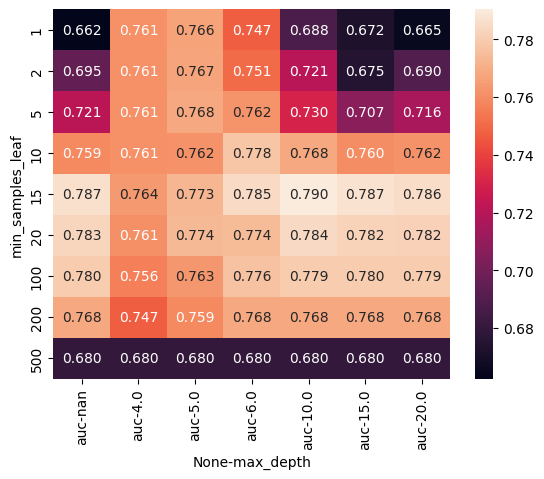

In [257]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [258]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

## Random Forest
- Suppose we have multiple classification models g_i that give independent predictions given some input data
- The predicitons are aggregated by averaging the individual prediction probabilities
- When the base models are decision trees, then the we a random forest
- The forest is called random because each model receives a different set of features to base predictions on

In [259]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [260]:
y_pred = rf.predict_proba(X_val)[:, 1]

In [261]:
roc_auc_score(y_val, y_pred)

0.7744726453706618

## Random Forest Parameter Tuning
n_estimators, max_depth, min_samples_leaf

In [262]:
scores = []
for n in range(10, 201, 10):
  rf = RandomForestClassifier(n_estimators=n, random_state=1)
  rf.fit(X_train, y_train)

  y_pred = rf.predict_proba(X_val)[:, 1]

  auc = roc_auc_score(y_val, y_pred)
  scores.append((n, auc))

In [263]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

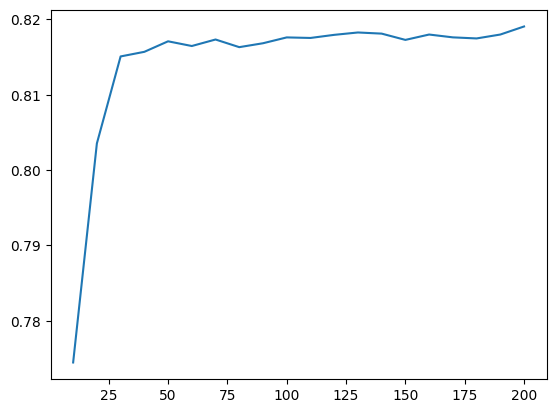

In [264]:
plt.plot(df_scores.n_estimators, df_scores.auc)
plt.show()

In [265]:
n = 100

In [266]:
scores = []
for d in [5, 10, 15]:
  for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append((d, n, auc))

In [267]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'auc'])

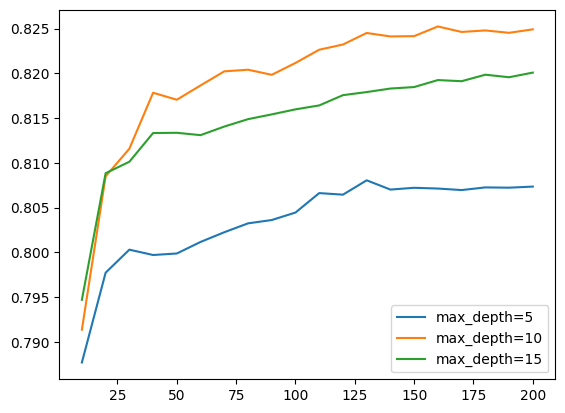

In [268]:
for d in [5, 10, 15]:
  df_subset = df_scores[df_scores.max_depth == d]
  plt.plot(df_subset.n_estimators, df_subset.auc, label=f'max_depth={d}')
plt.legend()
plt.show()

In [269]:
max_depth = 10

In [270]:
scores = []
for s in [1, 3, 5, 10, 50]:
  for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_leaf=s,  random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append((s, n, auc))

In [271]:
df_scores = pd.DataFrame(scores, columns=['min_samples_leaf', 'n_estimators', 'auc'])

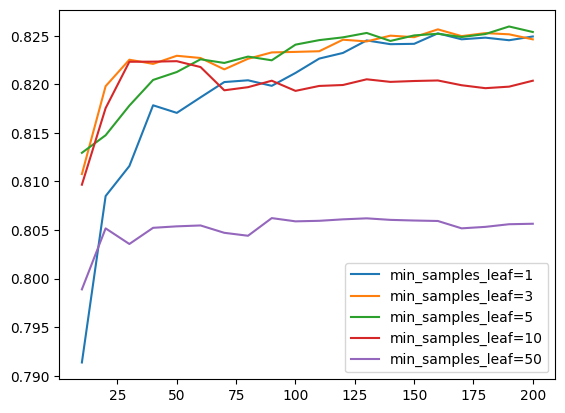

In [272]:
for s in [1, 3, 5, 10, 50]:
  df_subset = df_scores[df_scores.min_samples_leaf == s]
  plt.plot(df_subset.n_estimators, df_subset.auc, label=f'min_samples_leaf={s}')
plt.legend()
plt.show()

In [273]:
min_samples_leaf = 3

In [274]:
rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_leaf=min_samples_leaf,  random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

Other random forest params:
- bootstrap: selecting a subset of rows (datapoints) to feed each base model
- max_features: the maximum number of features to feed each base model
- n_jobs: parallelization of model training (-1 uses all available processors)

## Gradient Boosting and XGBoost
With a random forest, models are trained independently and their output is then combined to form the final model outout.

Gradient boosting train models sequentially:
- an initial model is trained on a dataset and makes predictions
- the next model takes the previous model's errors as input for training
- each subsequent model corrects the mistakes of the previous one

When each model in the sequence is a decision tree, we get a Gradient Boosting Tree

In [275]:
d_train = xgb.DMatrix(X_train, label=y_train, feature_names=list(dv.get_feature_names_out()))
d_val = xgb.DMatrix(X_val, label=y_val, feature_names=list(dv.get_feature_names_out()))
d_test = xgb.DMatrix(X_test, label=y_test, feature_names=list(dv.get_feature_names_out()))

In [276]:
xgb_params = {
  'eta': .3,
  'max_depth': 6,
  'min_child_weight': 1,
  'objective': 'binary:logistic',
  'nthread': 8,
  'seed': 1,
  'verbosity': 1
}

In [277]:
model = xgb.train(xgb_params, d_train, num_boost_round=200)

In [278]:
y_pred = model.predict(d_val)
roc_auc_score(y_val, y_pred)

0.8072491584122448

In [279]:
%%capture output

watchlist = [(d_train, 'train'), (d_val, 'val')]

xgb_params = {
  'eta': .3,
  'max_depth': 6,
  'min_child_weight': 1,
  'objective': 'binary:logistic',
  'eval_metric': 'auc',
  'nthread': 8,
  'seed': 1,
  'verbosity': 1
}

model = xgb.train(xgb_params, d_train, num_boost_round=200, evals=watchlist, verbose_eval=5)

In [280]:
def parse_xgb_output(output):
  results = []

  for line in output.stdout.strip().split('\n'):
    it_lin, train_line, val_line = line.split('\t')

    it = int(it_lin.strip('[]'))
    train = float(train_line.split(':')[1])
    val = float(val_line.split(':')[1])

    results.append((it, train, val))

  df_results = pd.DataFrame(results, columns=['iteration', 'auc_train', 'auc_val'])
  return df_results

In [281]:
df_score = parse_xgb_output(output)

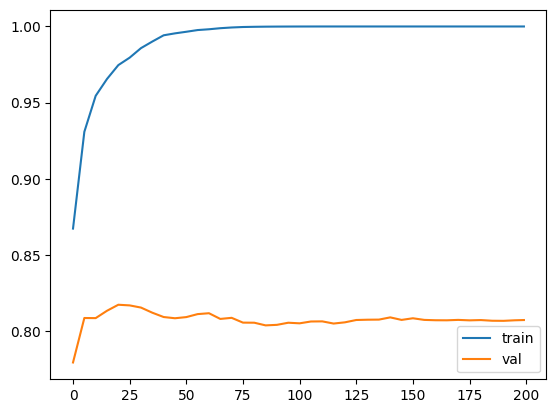

In [282]:
plt.plot(df_score.iteration, df_score.auc_train, label='train')
plt.plot(df_score.iteration, df_score.auc_val, label='val')
plt.legend()
plt.show()

## XGBoost Parameter Tuning
- eta (learning_rate): step size
- max_depth
- min_child_weight (min_samples_leaf)

### Eta

In [283]:
scores = {}

In [284]:
%%capture output

watchlist = [(d_train, 'train'), (d_val, 'val')]

xgb_params = {
  'eta': .01,
  'max_depth': 6,
  'min_child_weight': 1,
  'objective': 'binary:logistic',
  'eval_metric': 'auc',
  'nthread': 8,
  'seed': 1,
  'verbosity': 1
}

model = xgb.train(xgb_params, d_train, num_boost_round=200, evals=watchlist, verbose_eval=5)

In [285]:
key = f"eta={xgb_params['eta']}"
scores[key] = parse_xgb_output(output)

In [286]:
scores.keys()

dict_keys(['eta=0.01'])

In [287]:
etas = ['eta=0.05', 'eta=0.1', 'eta=0.01']

for eta in etas:
  df_score = scores[eta]
  plt.plot(df_score.iteration, df_score.auc_val, label=eta)
plt.legend()
plt.show()

KeyError: 'eta=0.05'

In [288]:
eta=.1

### Max Depth

In [289]:
scores = {}

In [290]:
%%capture output

watchlist = [(d_train, 'train'), (d_val, 'val')]

xgb_params = {
  'eta': eta,
  'max_depth': 10,
  'min_child_weight': 1,
  'objective': 'binary:logistic',
  'eval_metric': 'auc',
  'nthread': 8,
  'seed': 1,
  'verbosity': 1
}

model = xgb.train(xgb_params, d_train, num_boost_round=200, evals=watchlist, verbose_eval=5)

In [291]:
key = f"max_depth={xgb_params['max_depth']}"
scores[key] = parse_xgb_output(output)

In [292]:
scores.keys()

dict_keys(['max_depth=10'])

In [293]:
depths = ['max_depth=3', 'max_depth=4', 'max_depth=6', 'max_depth=10']

for depth in depths:
  df_score = scores[depth]
  plt.plot(df_score.iteration, df_score.auc_val, label=depth)
plt.ylim(.8, .84)
plt.legend()
plt.show()

KeyError: 'max_depth=3'

In [294]:
max_depth=3

### Min Child Weight

In [295]:
scores = {}

In [296]:
%%capture output

watchlist = [(d_train, 'train'), (d_val, 'val')]

xgb_params = {
  'eta': eta,
  'max_depth': max_depth,
  'min_child_weight': 50,
  'objective': 'binary:logistic',
  'eval_metric': 'auc',
  'nthread': 8,
  'seed': 1,
  'verbosity': 1
}

model = xgb.train(xgb_params, d_train, num_boost_round=200, evals=watchlist, verbose_eval=5)

In [297]:
key = f"min_child_weight={xgb_params['min_child_weight']}"
scores[key] = parse_xgb_output(output)

In [298]:
scores.keys()

dict_keys(['min_child_weight=50'])

In [299]:
weights = ['min_child_weight=1', 'min_child_weight=10', 'min_child_weight=30', 'min_child_weight=50']

for weight in weights:
  df_score = scores[weight]
  plt.plot(df_score.iteration, df_score.auc_val, label=weight)
plt.ylim(.82, .85)
plt.legend()
plt.show()

KeyError: 'min_child_weight=1'

In [300]:
min_child_weight = 30

### Final model

In [301]:
%%capture output

watchlist = [(d_train, 'train'), (d_val, 'val')]

xgb_params = {
  'eta': eta,
  'max_depth': max_depth,
  'min_child_weight': min_child_weight,
  'objective': 'binary:logistic',
  'eval_metric': 'auc',
  'nthread': 8,
  'seed': 1,
  'verbosity': 1
}

model = xgb.train(xgb_params, d_train, num_boost_round=175, evals=watchlist, verbose_eval=5)

# Model Selection
## Decision tree

In [302]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [303]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7850802838390931

## Random Forest

In [304]:
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=3,  random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

In [305]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8246258264512848

## Gradient Boosted tree

In [306]:
xgb_params = {
  'eta': .1,
  'max_depth': 3,
  'min_child_weight': 1,
  'objective': 'binary:logistic',
  'eval_metric': 'auc',
  'nthread': 8,
  'seed': 1,
  'verbosity': 1
}

model = xgb.train(xgb_params, d_train, num_boost_round=175)

In [307]:
y_pred = model.predict(d_val)
roc_auc_score(y_val, y_pred)

0.8309347073212081

In [308]:
df_train_full = df_train_full.reset_index(drop=True)
y_train_full = (df_train_full.status == 'default').astype(int).values

In [309]:
del df_train_full['status']

In [310]:
X_train_full, dv = encode_vars(df_train_full)
X_test, _ = encode_vars(df_test, dv)

In [ ]:
d_train_full = xgb.DMatrix(X_train_full, label=y_train_full, feature_names=list(dv.get_feature_names_out()))
d_test = xgb.DMatrix(X_test, label=y_test, feature_names=list(dv.get_feature_names_out()))

In [312]:
xgb_params = {
  'eta': .1,
  'max_depth': 3,
  'min_child_weight': 1,
  'objective': 'binary:logistic',
  'eval_metric': 'auc',
  'nthread': 8,
  'seed': 1,
  'verbosity': 1
}

model = xgb.train(xgb_params, d_train_full, num_boost_round=175)

In [314]:
y_pred = model.predict(d_test)
roc_auc_score(y_test, y_pred)

0.8335491911441278